In [1]:
pip_list = !pip list
packages = ["chardet", "dabl", "imblearn", "keras-tuner", "mysql-connector-python", "numpy", "pandas", "sklearn", "statsmodels", "tensorflow", "xgboost"]
for package in packages:
    if not pip_list.grep(package):
        !pip3 install {package}

print("Package installations completed.")

Package installations completed.


In [2]:
import datetime
import os
import shutil
import warnings
from pickle import dump

import chardet
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import tensorflow as tf
from IPython.display import display
from keras_tuner.tuners import BayesianOptimization, Hyperband, RandomSearch
from mysql.connector import errorcode
from sklearn import set_config
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib

%matplotlib inline
time_stamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
set_config(display="diagram", print_changed_only=False)
pd.set_option("display.float_format", lambda f: "%.2f" % f)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
plt.rc("axes", labelsize=12)
plt.rc("axes", titlesize=12)
plt.rc("font", size=10)
plt.rcParams["figure.figsize"] = [18, 7]
plt.style.use("dark_background")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore")

print(device_lib.list_local_devices())
print(tf.config.list_physical_devices("GPU"))
print(tf.test.gpu_device_name())
print(os.system("cat /proc/cpuinfo | grep 'model name'"))
print(os.system("cat /proc/meminfo | grep 'MemTotal'"))
print(os.system("nvidia-smi"))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9361705818713380655
]
[]

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
0
MemTotal:       32880876 kB
0
32512


sh: 1: nvidia-smi: not found


In [3]:
(
    graph_api_headers,
    rest_api_headers,
    devops_api_headers,
    devops_pat_headers,
    ea_api_headers,
) = [""] * 5


def timer(func):
    if asyncio.iscoroutinefunction(func):

        @functools.wraps(func)
        async def wrapper(*args, **kwargs):
            start_time = time.time()
            await func(*args, **kwargs)
            print(f"total runtime for async func: {time.time() - start_time}")

        return wrapper
    else:

        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            start_time = time.time()
            func(*args, **kwargs)
            print(f"total runtime for sync func: {time.time() - start_time}")

        return wrapper


def get_api_headers_decorator(func):
    @functools.wraps(func)
    async def wrapper(session, *args, **kwargs):
        return {
            "Authorization": f"Basic {base64.b64encode(bytes(os.environ[args[0]], 'utf-8')).decode('utf-8')}"
            if "PAT" in args[0]
            else f"Bearer {os.environ[args[0]] if 'EA' in args[0] else await func(session, *args, **kwargs)}",
            "Content-Type": "application/json-patch+json"
            if "PAT" in args[0]
            else "application/json",
        }

    return wrapper


@get_api_headers_decorator
async def get_api_headers(session, *args, **kwargs):
    oauth2_headers = {"Content-Type": "application/x-www-form-urlencoded"}
    oauth2_body = {
        "client_id": os.environ[args[0]],
        "client_secret": os.environ[args[1]],
        "grant_type": "client_credentials",
        "scope" if "GRAPH" in args[0] else "resource": args[2],
    }
    async with session.post(
        url=args[3], headers=oauth2_headers, data=oauth2_body
    ) as resp:
        return (await resp.json())["access_token"]


@timer
async with aiohttp.ClientSession() as session:
    (
        graph_api_headers,
        rest_api_headers,
        devops_api_headers,
        devops_pat_headers,
        ea_api_headers,
    ) = await asyncio.gather(
        *(get_api_headers(session, *param) for param in params)
    )
try:
    async def fetch(session, billing_period):
        print(f"starting {billing_period}.")
        async with session.get(
            url=f"https://consumption.azure.com/v3/enrollments/{ea}/billingPeriods/{billing_period}/balancesummary",
            headers=secondary_ea_api_headers,
        ) as resp:
            return (await resp.json())[0]["totalUsage"]


    async def generate():
        global prices
        async with aiohttp.ClientSession() as session:
            prices = await asyncio.gather(
                *(
                    fetch(session, "".join(billing_period.split("-")))
                    for billing_period in billing_periods
                )
            )
    asyncio.run(generate())

except mysql.connector.Error as e:
    if e.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with the user name or password")
    elif e.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
    else:
        print(e)

,Date,Bill
0,2020-02,117282
1,2020-03,125545
2,2020-04,129607
3,2020-05,156948
4,2020-06,174575
5,2020-07,193295
6,2020-08,201199
7,2020-09,197251
8,2020-10,212575
9,2020-11,220797


In [4]:
SEARCH = ["hyperband", "random", "bayesian"][0]
EPOCHS = 500
MAX_TRIALS = 20
DUPLICATES = 0
PLOT_PRED  = 1
N_PAST = 5
N_FUTURE = 1
ASFREQ = "MS"
FREQ = "1m"
DATE_COL = "Date"
y_label = "Bill"

print("-------------------------------------------------------")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Duplicates Percentage: {df.duplicated().sum() / df.shape[0] * 100:.2f}%")
if DUPLICATES:
    print(f"Duplicates have been kept {df.shape}.")
else:
    df.drop_duplicates(inplace=True)
    print(f"Duplicates have been removed {df.shape}.")
display(df.sample(3))

-------------------------------------------------------
Current Shape: (35, 2).
-------------------------------------------------------
Duplicates Percentage: 0.00%
Duplicates have been removed (35, 2).


,Date,Bill
24,2022-02,310787
9,2020-11,220797
3,2020-05,156948


In [5]:
df.dropna(subset=[y_label], inplace=True)
print("-------------------------------------------------------")
print(f"Dropping null target values.")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"y Value Counts:\n{df[y_label].value_counts()}")

-------------------------------------------------------
Dropping null target values.
Current Shape: (35, 2).
-------------------------------------------------------
y Value Counts:
117282    1
319611    1
280061    1
274711    1
287480    1
290243    1
310787    1
369642    1
383607    1
267990    1
334230    1
344321    1
351373    1
346814    1
387434    1
394204    1
260384    1
265435    1
125545    1
212575    1
129607    1
156948    1
174575    1
193295    1
201199    1
197251    1
220797    1
254661    1
221394    1
232990    1
254935    1
266175    1
257771    1
260245    1
401308    1
Name: Bill, dtype: int64


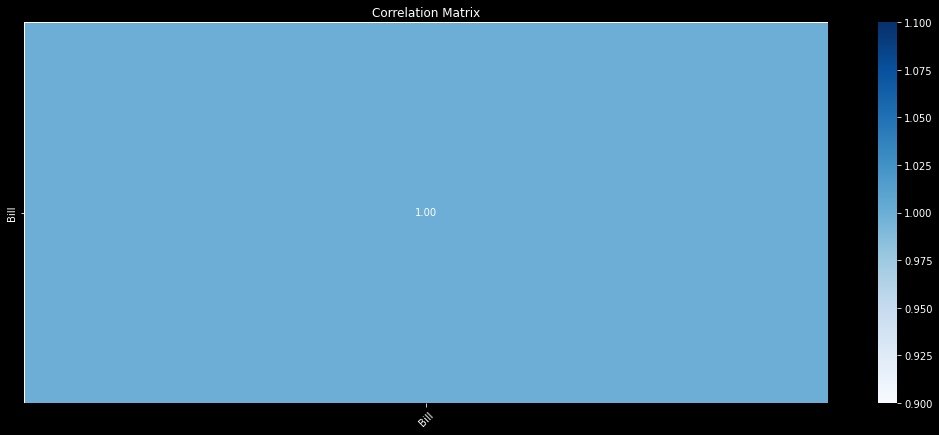

In [6]:
sns.heatmap(df.corr(), cmap="Blues", fmt=".2f", annot=True, linewidths=1)
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.show()

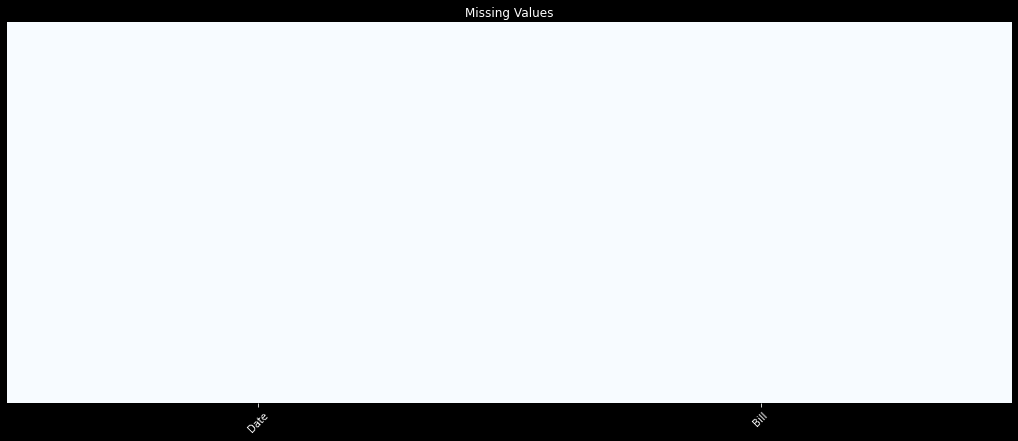

In [7]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="Blues")
plt.title("Missing Values")
plt.xticks(rotation=45)
plt.show()

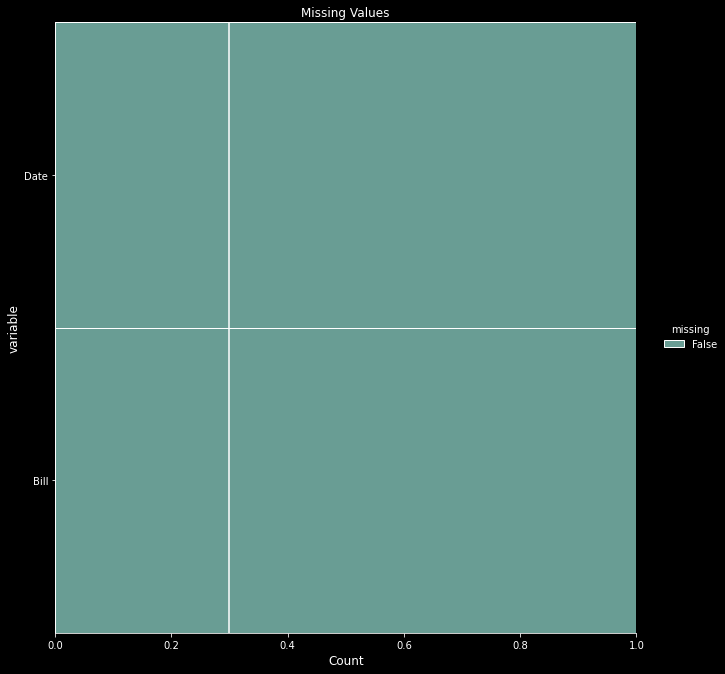

In [8]:
sns.displot(
    data=df.isnull().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    height=9.25,
)
plt.axvline(0.3, color="white")
plt.title("Missing Values")
plt.show()

In [9]:
"""
%a: Weekday, abbreviated: Mon, Tues, Sat
%A: Weekday, full name: Monday, Tuesday, Saturday
%w: Weekday, decimal. 0=Sunday: 1, 2, 6
%d: Day of month, zero-padded: 01, 02, 21
%b: Month, abbreviated: Jan, Feb, Sep
%B: Month, full name: January, February, September
%m: Month number, zero-padded: 01, 02, 09
%y: Year, without century, zero-padded: 02, 95, 99
%Y: Year, with century: 1990, 2020
%H: Hour (24 hour), zero padded: 01, 22
%I: Hour (12 hour) zero padded: 01, 12
%p: AM or PM: AM, PM
%M: Minute, zero-padded: 01, 02, 43
%S: Second, zero padded: 01, 32, 59
%f: Microsecond, zero-padded: 000001, 000342, 999999
%z: UTC offset ±HHMM[SS[.ffffff]]: +0000, -1030, -3423.234
%Z: Time zone name: ITC, EST, CST
%j: Day of year, zero-padded: 001, 365, 023
%U: Week # of year, zero-padded. Sunday first day of week: 00, 01, 51
%W: Week # of year, zero-padded. Monday first day of week: 00, 02, 51
%c: Appropriate date and time: Monday Feb 01 21:30:00 1990
%x: Appropriate Date: 02/01/90
%X: Appropriate Time: 21:22:00
"""
df.drop(df[df[DATE_COL].duplicated()].index, inplace=True)
df[y_label] = df[y_label].astype(float)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], format="%Y-%m-%dT%H:%M")
df = df.set_index(DATE_COL).sort_index().asfreq(ASFREQ)
df = df.interpolate(option="spline")
df = df[[y_label]]

In [10]:
col_cat_oe = []
col_cat = [col for col in df.columns if np.issubsctype(df[col].dtype, np.object0)]
col_num = [col for col in df.columns if np.issubsctype(df[col].dtype, np.number)]
col_cat_ohe = [col for col in col_cat if col not in col_cat_oe]
col_num_disc = [col for col in col_num if df[col].nunique() < 25]
col_num_cont = [col for col in col_num if col not in col_num_disc]
df_info = pd.DataFrame(
    {
        "column": [col for col in df.columns],
        "dtype": [f"{df[col].dtype}" for col in df.columns],
        "na": [f"{df[col].isna().sum()}" for col in df.columns],
        "na %": [f"{round(df[col].isna().sum() / df[col].shape[0] * 100)}%" for col in df.columns],
        "outliers": [f"{((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()}" if col in col_num else "n/a" for col in df.columns],
        "outliers %": [f"{round((((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()) / df[col].shape[0] * 100)}%" if col in col_num else "n/a" for col in df.columns],
        "kurtosis": [f"{df[col].kurtosis(axis=0, skipna=True):.2f}" if col in col_num else "n/a" for col in df.columns],
        "skewness": [f"{df[col].skew(axis=0, skipna=True):.2f}" if col in col_num else "n/a" for col in df.columns],
        "corr": [f"{round(df[col].corr(other=df[y_label]) * 100)}%" if col in col_num else "n/a" for col in df.columns],
        "nunique": [f"{df[col].nunique()}" for col in df.columns],
        "unique": [sorted(df[col].unique()) if col in col_num else df[col].unique() for col in df.columns],
    }
).sort_values(by="dtype", ascending=False)
display(df_info)
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"total na %: {df.isnull().sum().sum() / np.product(df.shape) * 100:.2f}%")
print("-------------------------------------------------------")
print(f"col_cat_oe ({len(col_cat_oe)}): {col_cat_oe}")
print(f"col_cat_ohe ({len(col_cat_ohe)}): {col_cat_ohe}")
print(f"col_num_disc ({len(col_num_disc)}): {col_num_disc}")
print(f"col_num_cont ({len(col_num_cont)}): {col_num_cont}")
print("-------------------------------------------------------")
print(f"total cols for preprocessor: {len(col_cat_oe) + len(col_cat_ohe) + len(col_num_disc) + len(col_num_cont)}")

,column,dtype,na,na %,outliers,outliers %,kurtosis,skewness,corr,nunique,unique
0,Bill,float64,0,0%,0,0%,-0.64,-0.09,100%,35,"[117282.0, 125545.0, 129607.0, 156948.0, 17457..."


Current Shape: (35, 1).
-------------------------------------------------------
total na %: 0.00%
-------------------------------------------------------
col_cat_oe (0): []
col_cat_ohe (0): []
col_num_disc (0): []
col_num_cont (1): ['Bill']
-------------------------------------------------------
total cols for preprocessor: 1


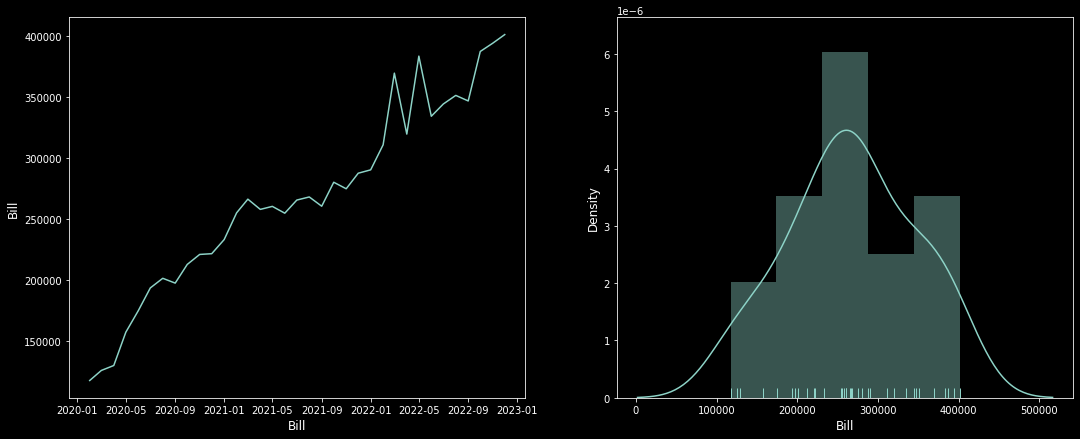

In [11]:
for col in col_num:
    fig, ax = plt.subplots(nrows=1, ncols=2)
    sns.lineplot(x=df.index, y=df[col], ax=ax[0]).set_xlabel(f"{col}")
    sns.distplot(x=df[col], ax=ax[1], rug=True).set_xlabel(f"{col}")
plt.show()

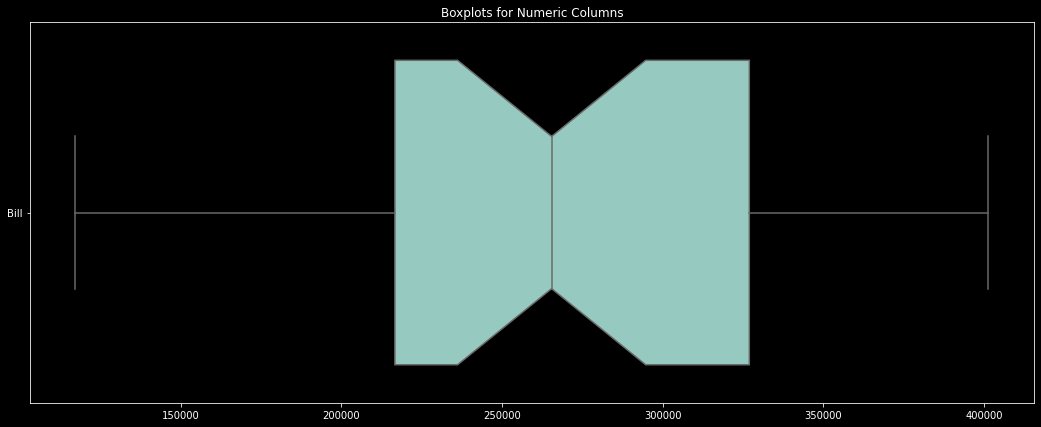

In [12]:
if col_num_cont:
    plt.title("Boxplots for Numeric Columns")
    sns.boxplot(data=df[[col for col in col_num_cont]], orient="h", notch=True)
    plt.show()

In [13]:
display(df.describe().T.style.background_gradient(cmap="Blues").format("{:.2f}"))
display(df.quantile([0.01, 0.99]).T.style.background_gradient(cmap="Blues").format("{:.2f}"))

,count,mean,std,min,25%,50%,75%,max
Bill,35.00,267053.71,78236.33,117282.00,216686.00,265435.00,326920.50,401308.00


,0.01,0.99
Bill,120091.42,398892.64


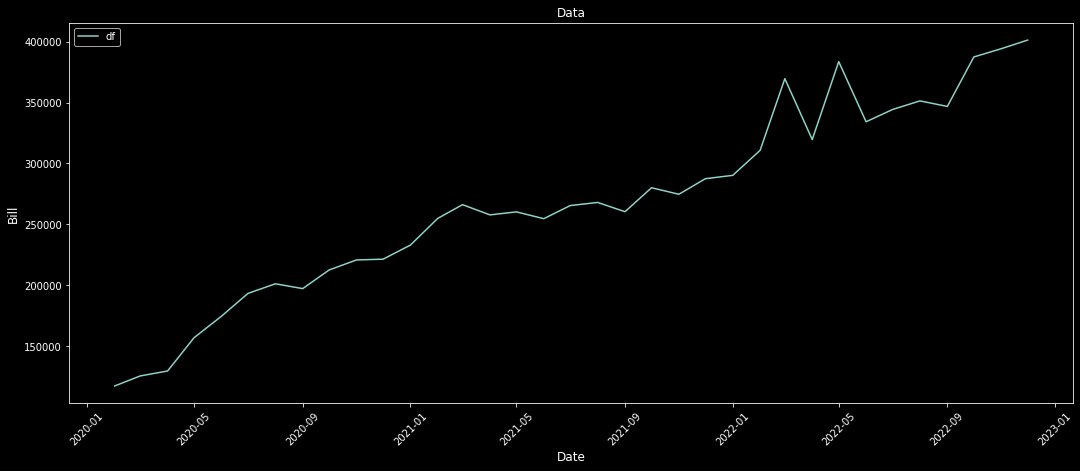

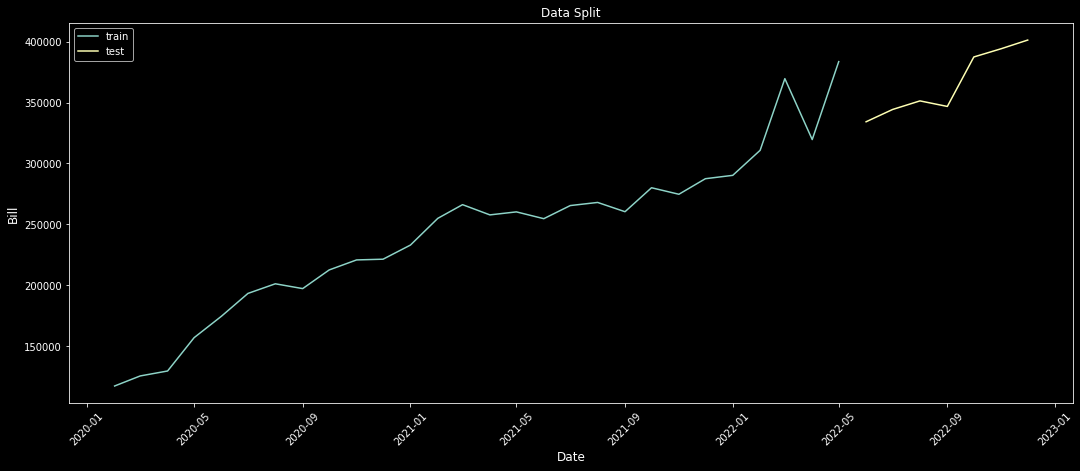

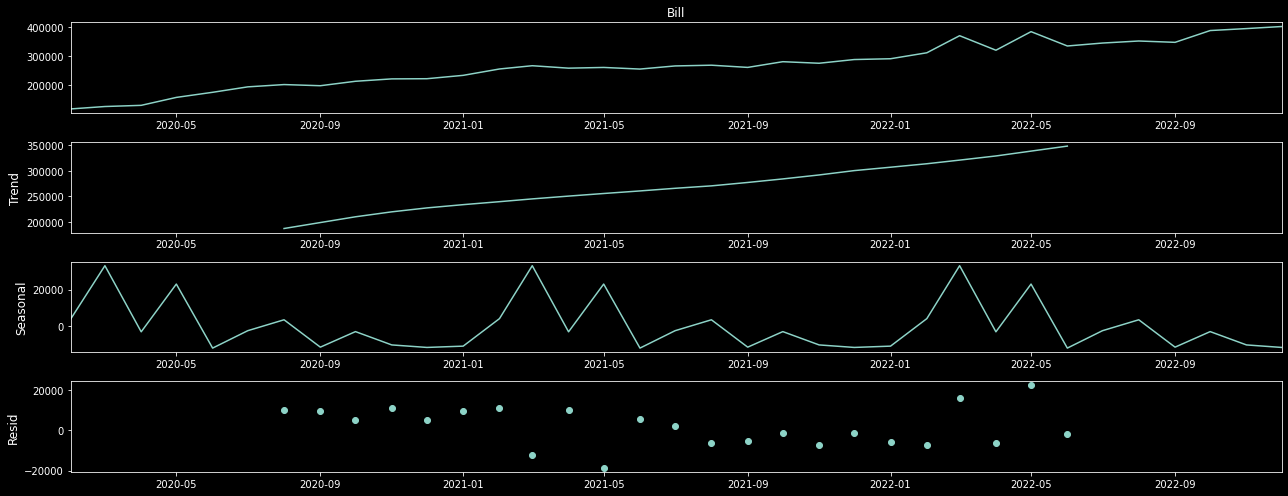

In [14]:
df_train, df_test = df.iloc[:round(df.shape[0]*0.8)], df.iloc[round(df.shape[0]*0.8):]

sns.lineplot(x=DATE_COL, y=y_label, data=df, label="df")
plt.title("Data")
plt.xticks(rotation=45)
plt.show()

sns.lineplot(x=DATE_COL, y=y_label, data=df_train, label="train")
sns.lineplot(x=DATE_COL, y=y_label, data=df_test, label="test")
plt.title("Data Split")
plt.xticks(rotation=45)
plt.show()

seasonal_decompose(df[y_label]).plot();

In [15]:
X_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(df_train)
X_test_scaled = X_scaler.transform(df_test)
y_train_scaled = y_scaler.fit_transform(df_train[[y_label]])
y_test_scaled = y_scaler.transform(df_test[[y_label]])

X_train = np.array([X_train_scaled[i : i + N_PAST] for i in range(len(X_train_scaled) - N_PAST - N_FUTURE + 1)])
X_test = np.array([X_test_scaled[i : i + N_PAST] for i in range(len(X_test_scaled) - N_PAST - N_FUTURE + 1)])
X_train_future = np.array([X_train_scaled[i : i + N_PAST] for i in range(len(X_train_scaled) - N_PAST - N_FUTURE + 1, len(X_train_scaled) - N_PAST + 1)])
X_test_future = np.array([X_test_scaled[i : i + N_PAST] for i in range(len(X_test_scaled) - N_PAST - N_FUTURE + 1, len(X_test_scaled) - N_PAST + 1)])
y_train = np.array([y_train_scaled[i + N_PAST + N_FUTURE - 1 : i + N_PAST + N_FUTURE, 0] for i in range(len(y_train_scaled) - N_PAST - N_FUTURE + 1)])
y_test = np.array([y_test_scaled[i + N_PAST + N_FUTURE - 1 : i + N_PAST + N_FUTURE, 0] for i in range(len(y_test_scaled) - N_PAST - N_FUTURE + 1)])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_train_future.shape, X_test_future.shape)

(23, 5, 1) (23, 1) (2, 5, 1) (2, 1) (1, 5, 1) (1, 5, 1)


In [16]:
def tune_dl_model(hp):
    model = keras.models.Sequential()
    model.add(
        keras.layers.LSTM(
            units=hp.Int("input_00_unit", min_value=32, max_value=512, step=32),
            return_sequences=True,
            input_shape=X_train.shape[1:],
        )
    )
    model.add(
        keras.layers.LSTM(
            units=hp.Int("lstm_01_unit", min_value=32, max_value=512, step=32),
            return_sequences=False,
        )
    )
    model.add(keras.layers.Dropout(hp.Float("dropout", min_value=0, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(units=1, activation="linear"))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
        loss="mean_squared_error",
        metrics="mean_squared_error",
    )
    return model


def train_dl_model():
    tuner.search(
        X_train,
        y_train,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        callbacks=[early_stop],
        epochs=MAX_TRIALS,
        validation_split=0.2,
        verbose=1,
    )
    tuner.results_summary()

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(
        X_train,
        y_train,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        epochs=EPOCHS,
        validation_split=0.2,
        verbose=1,
    )
    val_per_epoch = history.history["val_mean_squared_error"]
    best_epoch = val_per_epoch.index(min(val_per_epoch)) + 1

    plt.subplot(1, 2, 1)
    sns.lineplot(data=history.history["mean_squared_error"], color="deeppink", linewidth=2.5)
    sns.lineplot(data=history.history["val_mean_squared_error"], color="darkturquoise", linewidth=2.5)
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Training Accuracy", "Val Accuracy"], loc="lower right")
    plt.grid()

    plt.subplot(1, 2, 2)
    sns.lineplot(data=history.history["loss"], color="deeppink", linewidth=2.5)
    sns.lineplot(data=history.history["val_loss"], color="darkturquoise", linewidth=2.5)
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Training Loss", "Val Loss"], loc="upper right")
    plt.grid()
    plt.show()
    
    print(f"Best epoch: {best_epoch}")
    
    return best_epoch, best_hps


def build_dl_model(best_epoch, best_hps):
    model = tuner.hypermodel.build(best_hps)
    model.fit(
        X_train,
        y_train,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        epochs=best_epoch,
        validation_split=0.2,
        verbose=1,
    )
    actual_train = y_scaler.inverse_transform(y_train)
    actual_test = y_scaler.inverse_transform(y_test)
    pred_train = y_scaler.inverse_transform(model.predict(X_train))
    pred_test = y_scaler.inverse_transform(model.predict(X_test))
    pred_train_future = y_scaler.inverse_transform(model.predict(X_train_future))
    pred_test_future = y_scaler.inverse_transform(model.predict(X_test_future))
    df_train_pred = pd.DataFrame(pred_train, columns=[y_label], index=pd.date_range(df_train.index[N_PAST+N_FUTURE-1], periods=pred_train.shape[0], freq=FREQ, name=DATE_COL))
    df_test_pred = pd.DataFrame(pred_test, columns=[y_label], index=pd.date_range(df_test.index[N_PAST+N_FUTURE-1], periods=pred_test.shape[0], freq=FREQ, name=DATE_COL))
    df_train_future_pred = pd.DataFrame(pred_train_future, columns=[y_label], index=pd.date_range(df_train.index[-1], periods=N_FUTURE, freq=FREQ, name=DATE_COL))
    df_test_future_pred = pd.DataFrame(pred_test_future, columns=[y_label], index=pd.date_range(df_test.index[-1], periods=N_FUTURE, freq=FREQ, name=DATE_COL))

    print("-------------------------------------------------------")
    print(f"r2: {r2_score(actual_test, pred_test):.3f} neg_mean_squared_error: -{mean_squared_error(actual_test, pred_test):_.3f} (Test)")
    print(f"r2: {r2_score(actual_train, pred_train):.3f} neg_mean_squared_error: -{mean_squared_error(actual_train, pred_train):_.3f} (Train)")
    print("-------------------------------------------------------")
    plt.subplot(1, 3, 1)
    sns.regplot(actual_train, actual_train, color="darkorange", label="Truth")
    sns.regplot(
        actual_test,
        pred_test,
        color="darkcyan",
        label="Predicted",
    )
    plt.title(
        "Truth vs Predicted",
        fontsize=10,
    )
    plt.xlabel("Truth values")
    plt.ylabel("Predicted values")
    plt.legend()
    plt.grid()

    plt.subplot(1, 3, 2)
    sns.scatterplot(
        data=pd.DataFrame(
            {
                "Predicted values": pred_train.flatten(),
                "Residuals": pred_train.flatten() - actual_train.flatten(),
            }
        ),
        x="Predicted values",
        y="Residuals",
        color="darkorange",
        marker="o",
        s=35,
        alpha=0.5,
        label="Train data",
    )
    sns.scatterplot(
        data=pd.DataFrame(
            {
                "Predicted values": pred_test.flatten(),
                "Residuals": pred_test.flatten() - actual_test.flatten(),
            }
        ),
        x="Predicted values",
        y="Residuals",
        color="darkcyan",
        marker="o",
        s=35,
        alpha=0.7,
        label="Test data",
    )
    plt.title(
        "Predicted vs Residuals",
        fontsize=10,
    )
    plt.hlines(y=0, xmin=0, xmax=df[y_label].max(), lw=2, color="red")
    plt.grid()

    plt.subplot(1, 3, 3)
    sns.distplot(actual_train - pred_train)
    plt.title("Error Terms")
    plt.xlabel("Errors")
    plt.grid()
    plt.show()

    sns.lineplot(x=DATE_COL, y=y_label, data=df_train, label="train")
    sns.lineplot(x=DATE_COL, y=y_label, data=df_test, label="test")
    sns.lineplot(x=DATE_COL, y=y_label, data=df_train_pred, label="train_pred")
    sns.lineplot(x=DATE_COL, y=y_label, data=df_test_pred, label="test_pred")
    sns.lineplot(x=DATE_COL, y=y_label, data=df_train_future_pred, label="train_future_pred")
    sns.lineplot(x=DATE_COL, y=y_label, data=df_test_future_pred, label="test_future_pred")
    if PLOT_PRED:
        pred_future = []
        current_batch = X_test[-1:]
        for _ in range(N_PAST):
            current_pred = model.predict(current_batch)[0]
            pred_future.append(current_pred) 
            current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)
        df_future_pred = pd.DataFrame(y_scaler.inverse_transform(pred_future), columns=[y_label], index=pd.date_range(df_test.index[-1], periods=N_PAST, freq=FREQ, name=DATE_COL))
        sns.lineplot(x=DATE_COL, y=y_label, data=df_future_pred, label="future_pred")
    plt.axvline(x=max(df_train_pred.index), color='green', linewidth=2, linestyle='--')
    plt.axvline(x=max(df_test_pred.index), color='red', linewidth=2, linestyle='--')
    plt.title("Prediction")
    plt.xlabel("Timeline")
    plt.xticks(rotation=45)
    plt.legend(shadow=True)
    plt.grid(which="major", color="#cccccc", alpha=0.5)
    plt.show()

    df.loc[df_train_future_pred.index[0]:df_train_future_pred.index[-1]][y_label]
    df_train_future_pred["Actual"] = df.loc[df_train_future_pred.index[0]:df_train_future_pred.index[-1]][y_label]
    display(df_train_future_pred[:10])
    display(df_test_future_pred)
    if PLOT_PRED:
        display(df_future_pred)

    return model


if SEARCH == "hyperband":
    tuner = Hyperband(
        tune_dl_model,
        objective="val_mean_squared_error",
        max_epochs=MAX_TRIALS,
        factor=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
elif SEARCH == "random":
    tuner = RandomSearch(
        tune_dl_model,
        objective="val_mean_squared_error",
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
else:
    tuner = BayesianOptimization(
        tune_dl_model,
        objective="val_mean_squared_error",
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=int(MAX_TRIALS/4))
tuner.search_space_summary()

2022-12-18 02:26:48.650890: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Search space summary
Default search space size: 4
input_00_unit (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
lstm_01_unit (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


Trial 30 Complete [00h 00m 06s]
val_mean_squared_error: 0.05393271520733833

Best val_mean_squared_error So Far: 0.01021038182079792
Total elapsed time: 00h 03m 17s
Results summary
Results in ./keras_tuner
Showing 10 best trials
Trial summary
Hyperparameters:
input_00_unit: 416
lstm_01_unit: 128
dropout: 0.30000000000000004
learning_rate: 0.001
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022
Score: 0.01021038182079792
Trial summary
Hyperparameters:
input_00_unit: 224
lstm_01_unit: 64
dropout: 0.2
learning_rate: 0.01
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.010300149209797382
Trial summary
Hyperparameters:
input_00_unit: 416
lstm_01_unit: 352
dropout: 0.2
learning_rate: 0.001
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0023
Score: 0.01030031032860279
Trial summary
Hyperparameters:
input_00_unit: 416
lstm_01_unit: 128
dropout: 0.30000000000000004
learning_rate: 

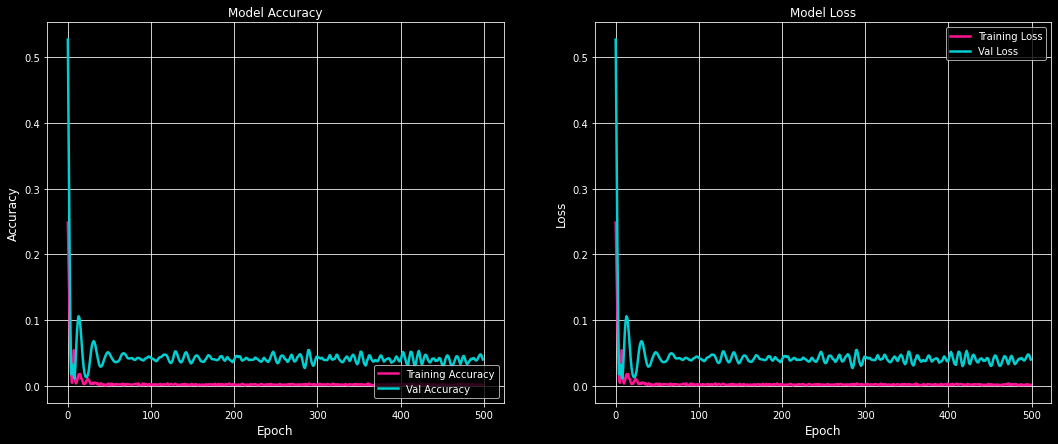

Best epoch: 9
Epoch 1/9
1/1 [==============================] - 5s 5s/step - loss: 0.2407 - mean_squared_error: 0.2407 - val_loss: 0.5223 - val_mean_squared_error: 0.5223
Epoch 2/9
1/1 [==============================] - 0s 62ms/step - loss: 0.1746 - mean_squared_error: 0.1746 - val_loss: 0.3776 - val_mean_squared_error: 0.3776
Epoch 3/9
1/1 [==============================] - 0s 60ms/step - loss: 0.1168 - mean_squared_error: 0.1168 - val_loss: 0.2390 - val_mean_squared_error: 0.2390
Epoch 4/9
1/1 [==============================] - 0s 58ms/step - loss: 0.0647 - mean_squared_error: 0.0647 - val_loss: 0.1128 - val_mean_squared_error: 0.1128
Epoch 5/9
1/1 [==============================] - 0s 61ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - val_loss: 0.0250 - val_mean_squared_error: 0.0250
Epoch 6/9
1/1 [==============================] - 0s 59ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0156 - val_mean_squared_error: 0.0156
Epoch 7/9
1/1 [=========================

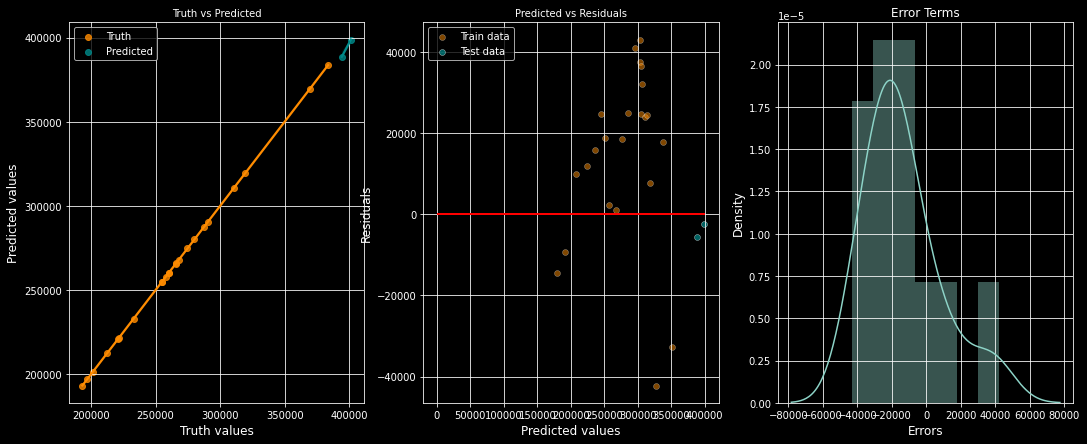

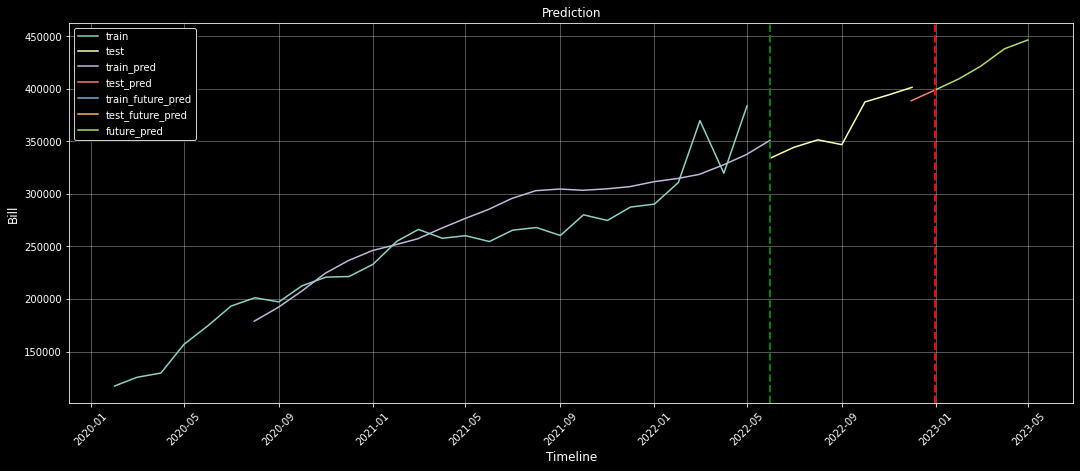

,Bill,Actual
Date,,
2022-05-31,366867.44,NaN


,Bill
Date,
2022-12-31,409646.34


,Bill
Date,
2022-12-31,398784.20
2023-01-31,409456.91
2023-02-28,421388.88
2023-03-31,438005.15
2023-04-30,446257.10


In [17]:
model = build_dl_model(*train_dl_model())

2022-12-18 02:31:00.121881: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 5, 416)            695552    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               279040    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 974,721
Trainable params: 974,721
Non-trainable params: 0
_________________________________________________________________


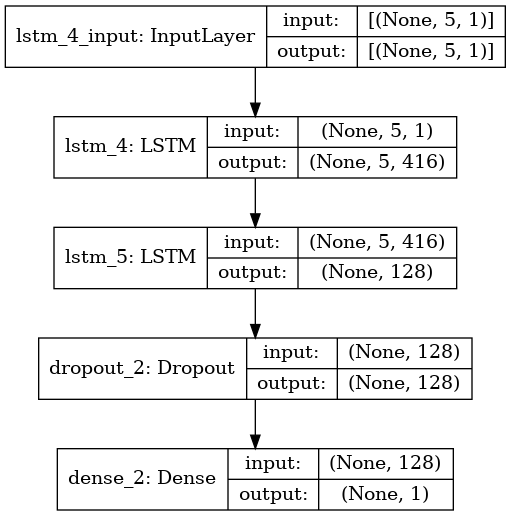

In [18]:
model.save(f"dl_model_{time_stamp}")
shutil.make_archive(f"dl_model_{time_stamp}", "zip", f"./dl_model_{time_stamp}")
model.summary()
plot_model(model, show_shapes=True)